In this notebook we launch the following pipeline
- comparison of variences between 75_regions dataset and OneBatch dataset
- estimation of the parameters of lipids distributions in OneBatch
- generation of fake brains from the estimated distributions
- applying Random Forest ML algorithm to the generated data
- identifying the most important features

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
onebatch = pd.read_csv("../data/OneBatch3_FINAL2.csv")

In [3]:
h_lipids = pd.read_csv("../data/ours_maria_version/rtmz_H_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)
sz_lipids = pd.read_csv("../data/ours_maria_version/rtmz_SZ_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)

h_lipids.index = h_lipids.index.str.split(".").str[0]

meta = pd.read_csv("../data/ours_maria_version/meta_pos_COMBINED.csv")
meta = meta[["Sample", "Brain_abbr", "Region_detailed"]].set_index("Sample")

sz_lipids = meta.join(sz_lipids, how="inner")
sz_lipids["region_id"] = sz_lipids.Region_detailed.str.split(" ").str[0].astype(int)

h_lipids = meta.join(h_lipids, how="inner")
h_lipids["region_id"] = h_lipids.Region_detailed.str.split(" ").str[0].astype(int)

In [4]:
meta_lipids = pd.read_csv("../data/ours_maria_version/TL_combined.csv")

In [5]:
h_lipids.columns = ["Brain_abbr", "Region_detailed"] + meta_lipids["Lipid.species"].str.replace(":", " ", regex=False).tolist() + ["region_id"]
sz_lipids.columns = ["Brain_abbr", "Region_detailed"] + meta_lipids["Lipid.species"].str.replace(":", " ", regex=False).tolist() + ["region_id"]

In [6]:
regions_75_lipids = meta_lipids["Lipid.species"].str.replace(":", " ").unique().tolist()
onetabch_lipids = onebatch.columns[9:].str.replace(".", " ", regex=False).tolist()
common_lipids = list(set(regions_75_lipids) & set(onetabch_lipids))
print("Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids")
print(len(regions_75_lipids), len(onetabch_lipids), len(common_lipids))
duplicates = h_lipids.columns.value_counts()[h_lipids.columns.value_counts() != 1].index
print("Common lipids after removing duplicates")
common_lipids = list(set(common_lipids) - set(duplicates))
len(common_lipids)

Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids
347 445 58
Common lipids after removing duplicates


53

In [7]:
onebatch.columns = onebatch.columns.str.replace(".", " ", regex=False)
onebatch_only_common = onebatch[onebatch.columns[:9].tolist() + common_lipids]
onebatch_only_common.head()

,Unnamed: 0,Sample,SZ,Type,Region,Donor,Order,Mass,MassCoef,PC 37 4,...,PC 39 6,FA 26 1,FA 22 1,LPE 22 4,PC 40 4,FA 24 1,LPC 18 1,FA 18 2,FA 16 1,LPE 22 6
0,V19,HC10M_f_36_BA22p_x2_NEG_093,HC,Sample,CCp,HC10M,93,24.9,0.371845,20.528720,...,19.646327,19.665545,17.533708,21.150884,21.825713,18.021502,22.301464,19.802236,18.926980,21.256991
1,V20,HC10M_f_36_BA9_x2_NEG_041,HC,Sample,BA9,HC10M,41,16.4,-0.230605,21.056039,...,20.522596,13.190107,14.870293,21.667137,19.053217,13.704161,23.236950,19.929304,17.773405,24.423648
2,V21,HC10M_f_36_CCa_x2_NEG_092,HC,Sample,Cca,HC10M,92,21.1,0.132942,20.395336,...,19.377684,19.365424,17.826063,21.378536,21.056548,18.251102,22.727333,20.682577,19.851671,21.670136
3,V22,HC10M_f_36_CCp_x2_NEG_068,HC,Sample,BA22,HC10M,68,18.6,-0.048999,21.379987,...,21.172934,15.128922,15.486478,22.058812,19.263272,14.614521,23.777047,20.781089,18.194871,25.143806
4,V23,HC16M_f_54_BA22p_x2_NEG_006,HC,Sample,BA22,HC16M,6,14.6,-0.398333,20.998287,...,20.615993,16.958647,16.381023,22.127205,19.859302,15.986056,22.859857,18.941289,18.169637,23.747059


- BA9: 35 Dorsolateral Prefrontal Medial (BA9m), 34 Dorsolateral Prefrontal (BA9)
- BA22: 26 2ary Auditory, language (BA22a), 28 2ary Auditory, Wernicke (BA22p)

In [8]:
region_translate = {
    "CCp": '74 Corpus Callosum Posterior',
    "BA9": "34 Dorsolateral Prefrontal (BA9)",
    "Cca": '73 Corpus Callosum Anterior',
    "BA22": "28 2ary Auditory, Wernicke (BA22p)",
}

In [9]:
fake_dataset = []

table = []
for human_type in ["HC", "SZ"]:
    for region_nm in onebatch.Region.unique():
        to_plot = onebatch_only_common[(onebatch_only_common.SZ == human_type) & (onebatch_only_common.Region == region_nm)]

        onebatch_lipids = to_plot[common_lipids]
        if human_type == "HC":
            regions_75_lipids = h_lipids[h_lipids["Region_detailed"] == region_translate[region_nm]][common_lipids]
        else:
            regions_75_lipids = sz_lipids[sz_lipids["Region_detailed"] == region_translate[region_nm]][common_lipids]
        table.append([human_type, region_nm, (onebatch_lipids.var() / regions_75_lipids.var()).mean()])
        generated = np.random.normal(loc=onebatch_lipids.mean(), scale=onebatch_lipids.var(), size=(1000, 53))
        fake_dataset.append(generated)
pd.DataFrame(np.array(table), columns=["SZ", "region", "mean fold-change"])

,SZ,region,mean fold-change
0,HC,CCp,3.8584557776914075
1,HC,BA9,8.845302318834811
2,HC,Cca,10.414131370864434
3,HC,BA22,4.583070182642497
4,SZ,CCp,15.186059929472062
5,SZ,BA9,62.22744646999254
6,SZ,Cca,3.0123983251629682
7,SZ,BA22,7.210816332870764


In [10]:
hc_fake = np.hstack(fake_dataset[:4])
sz_fake = np.hstack(fake_dataset[4:])
fake_dataset = np.vstack([hc_fake, sz_fake])

In [11]:
pd.Series(common_lipids)

0      PC 37 4
1     CAR 18 1
2     LPC 18 0
3      FA 22 3
4      FA 20 1
5      FA 22 4
6      PC 42 4
7     LPE 20 2
8      FA 17 0
9     LPC 20 3
10     FA 20 5
11     PC 42 9
12    LPC 20 1
13     PC 37 1
14    LPC 22 4
15     PC 35 3
16     PC 42 2
17    LPE 18 1
18    LPC 20 4
19     FA 22 0
20     FA 20 4
21    LPC 22 5
22     FA 16 0
23     FA 20 0
24     PC 34 2
25     FA 24 5
26     FA 24 4
27    LPE 18 0
28     PC 37 2
29    LPE 16 0
30     PC 42 7
31     FA 18 1
32     FA 22 6
33    LPE 20 1
34    LPC 22 6
35     FA 20 3
36    LPE 24 4
37     PC 37 5
38     FA 22 2
39    CAR 18 0
40     FA 22 5
41     PC 42 8
42    LPE 20 4
43     PC 39 6
44     FA 26 1
45     FA 22 1
46    LPE 22 4
47     PC 40 4
48     FA 24 1
49    LPC 18 1
50     FA 18 2
51     FA 16 1
52    LPE 22 6
dtype: object

In [12]:
feature_names = []
for region_nm in onebatch.Region.unique():
    feature_names += ((region_nm + "_") + pd.Series(common_lipids)).values.tolist()

feature_names = np.array(feature_names)

y = np.ones(2000)
y[:1000] = 0

rf = RandomForestClassifier()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(fake_dataset, y, test_size=0.2, shuffle=True)

In [14]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
accuracy_score(rf.predict(X_test), y_test)

1.0

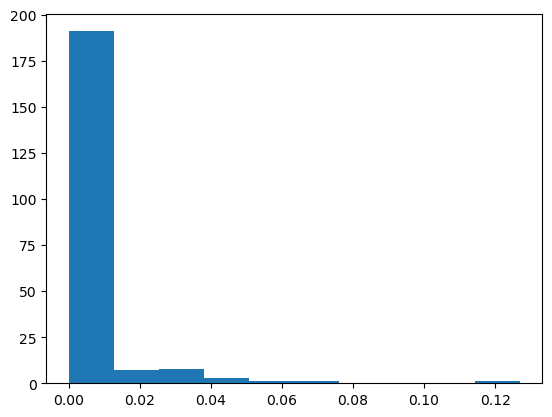

In [16]:
plt.hist(rf.feature_importances_)
plt.show()

In [18]:
print(feature_names[rf.feature_importances_ > .02])

['CCp_FA 22 4' 'CCp_PC 42 2' 'CCp_FA 18 1' 'CCp_FA 20 3' 'CCp_FA 26 1'
 'CCp_FA 22 1' 'BA9_LPC 18 0' 'BA9_PC 34 2' 'Cca_FA 20 1' 'Cca_FA 22 4'
 'Cca_FA 20 4' 'Cca_FA 18 1' 'Cca_FA 20 3' 'Cca_FA 22 2' 'Cca_FA 22 1'
 'BA22_PC 37 4']
